In [1]:
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import integrate, signal, stats, fftpack
from glob import glob
import time

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, get_evoked_traces

In [5]:
from PCIst.PCIst.pci_st import calc_PCIst

In [6]:
%matplotlib notebook

## Functions

#### Plot electrodes

## Load exp instance for all visual experiments

In [7]:
visexpdirs = {
    'sigtest': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551397\signal_test_2021-01-20_14-24-42\experiment1\recording1',
    'vis1': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551397\vis1_2021-01-29_09-40-43\experiment1\recording1',
    'vis2': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551397\vis2_2021-01-29_10-00-27\experiment1\recording1',
    'vis3': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551397\vis3_2021-01-29_10-09-19\experiment1\recording1',
    'vis4': r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse551397\vis4_2021-02-04_10-05-09\experiment1\recording1',
}

In [8]:
vis_exp = {}
for visi, recdiri in visexpdirs.items():
    vis_exp[visi] = EEGexp(recdiri, preprocess=False, make_stim_csv=False)

Experiment type: sensory stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.
Experiment type: sensory stimulation
SomnoSuite log file not found.
Experiment type: sensory stimulation
SomnoSuite log file not found.
Experiment type: sensory stimulation
SomnoSuite log file not found.
Experiment type: sensory stimulation
SomnoSuite log file not found.


In [9]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots', 'mouse'+vis_exp['vis1'].mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

For 551397, monitor on right side:
<br>sigtest, regular white flashes on black background: sweep 0-ref=front and Lcb screws, sweep 1-ref=front screw, sweep 2-ref=Lcb screw, sweep 3-ref=gnd
<br>vis1, regular white flashes on black background: sweep 0-both eyes, sweep 1-left eye covered
<br>vis2, regular white flashes on black background: sweep 0-right eye covered, sweep 1-both eyes
<br>vis3, white/black flashes on gray background: sweep 0-both eyes, sweep 1-right eye covered, sweep 2-left eye covered
<br>vis4: sweep 0-20ms white flashes on black bg, sweep 1-white/gabor circles on black bg, sweep 2-white/gabor circles on gray bg

### Stim evoked raw traces

In [10]:
eeg_chs = np.arange(0, EEGexp.EEG_channel_order.shape[0])

before_event = 0.5 # s, look at 100 ms pre-stim
after_event = 1.0 # s, look at 500 ms post-stim

low_pass_cutoff = 100

In [11]:
## Loop through all stim events/sweeps and collect traces
traces = {}
filtered_traces = {}
goodchlist = []
for testi, expi in vis_exp.items():
    print(testi)
    traces[testi] = {}
    filtered_traces[testi] = {}

    eeg_data, eeg_ts = expi.load_eegdata(load_empty_chs=True)
    stim_log, good_chs = expi.qualitycheck_trials_chs()
    
    for st_type in stim_log.stim_type.unique():
        traces[testi][st_type] = {}
        filtered_traces[testi][st_type] = {}

        param_list = np.sort(stim_log.loc[stim_log.stim_type == st_type, 'parameter'].unique())
        for parami in param_list:
            traces[testi][st_type][parami] = {}
            filtered_traces[testi][st_type][parami] = {}
            
            param_mask = (stim_log.stim_type == st_type) & (stim_log.parameter == parami)
            for sweepi in np.sort(stim_log.loc[param_mask, 'sweep'].unique()):
                ## Get event times ##
                events = get_stim_events(stim_log, st_type, parami, sweepi)
                if len(events) == 0:
                    print('{}, {}, sweep {:d}: no good trials found'.format(st_type, str(parami), sweepi))
                    continue
                print('{}, {}, sweep {:d}: {:d} good trials'.format(st_type, str(parami), sweepi, len(events)))
                ## Get event traces ##
                event_traces, event_ts = get_evoked_traces(
                    eeg_data,
                    eeg_ts,
                    events,
                    before_event,
                    after_event,
                    expi.ephys_params['EEG']['sample_rate']
                )
                # design/apply lowpass Butterworth filter
                filtb, filta = signal.butter(3, 100/(expi.ephys_params['EEG']['sample_rate']/2), btype='low')
                filttraces = signal.filtfilt(filtb, filta, event_traces, axis=0)

                ## Store traces ##
                traces[testi][st_type][parami][sweepi] = [event_ts, event_traces]
                filtered_traces[testi][st_type][parami][sweepi] = [event_ts, np.mean(filttraces, axis=2)]
                goodchlist.append(good_chs[st_type][parami][sweepi])
                
    del eeg_data
    del eeg_ts
    del stim_log
    
all_good_chs = np.array(list(set.intersection(*map(set, goodchlist))))
print(all_good_chs)

sigtest
fullscreen, white, sweep 0: 40 good trials
fullscreen, white, sweep 1: 39 good trials
fullscreen, white, sweep 2: 40 good trials
fullscreen, white, sweep 3: 40 good trials
vis1
fullscreen, white, sweep 0: 39 good trials
fullscreen, white, sweep 1: 40 good trials
vis2
fullscreen, white, sweep 0: 40 good trials
fullscreen, white, sweep 1: 40 good trials
vis3
fullscreen, black, sweep 0: 40 good trials
fullscreen, black, sweep 1: 39 good trials
fullscreen, black, sweep 2: 40 good trials
fullscreen, white, sweep 0: 39 good trials
fullscreen, white, sweep 1: 40 good trials
fullscreen, white, sweep 2: 40 good trials
vis4
fullscreen, white, sweep 0: 99 good trials
circle, gabor, sweep 1: 100 good trials
circle, gabor, sweep 2: 99 good trials
circle, white, sweep 1: 99 good trials
circle, white, sweep 2: 100 good trials
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]


#### Get common average and common average traces

In [12]:
## Loop through all stim events/sweeps and collect traces
comavg_filtered_traces = {}
comavg = {}
for testi in traces.keys():
    comavg_filtered_traces[testi] = {}
    comavg[testi] = {}
    
    for st_type in traces[testi].keys():
        comavg_filtered_traces[testi][st_type] = {}
        comavg[testi][st_type] = {}

        for parami in traces[testi][st_type].keys():
            comavg_filtered_traces[testi][st_type][parami] = {}
            comavg[testi][st_type][parami] = {}

            for sweepi, datai in traces[testi][st_type][parami].items():
                event_ts = datai[0]
                event_traces = datai[1]
                GOOD_CHS = all_good_chs # good_chs[st_type][parami][sweepi][0]

                ## CAR event traces ##
                comavg[testi][st_type][parami][sweepi] = np.mean(event_traces[:, GOOD_CHS, :], axis=1)
                comavg_traces = event_traces - np.mean(event_traces[:, GOOD_CHS, :], axis=1)[:,None,:]

                # apply lowpass Butterworth filter
                filtb, filta = signal.butter(3, 100/(vis_exp[testi].ephys_params['EEG']['sample_rate']/2), btype='low')
                filttraces = signal.filtfilt(filtb, filta, comavg_traces, axis=0)

                ## Store traces ##
                comavg_filtered_traces[testi][st_type][parami][sweepi] = [event_ts, np.mean(filttraces, axis=2)]

## Compare raw traces to common average traces

Show that common average shows true(?) topography of VEPs. Looking at vis4, sweep 2.

<IPython.core.display.Javascript object>


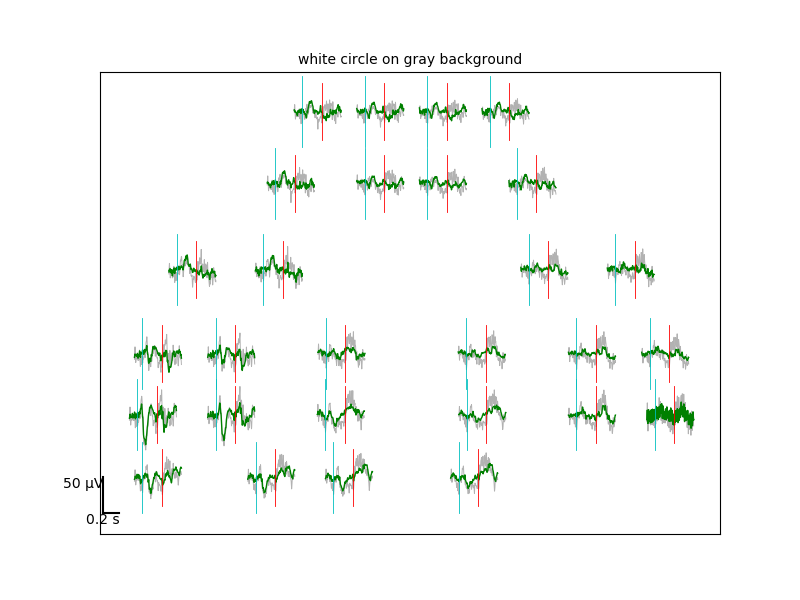

In [14]:
plexp = 'vis4'
plstim = 'circle'
plparam = 'white'
plsweep = 2

prex = .1 # s before stim to plot
postx = .5 # s after stim to plot
xmult = 0.8
ymult = 80

rawtimex = filtered_traces[plexp][plstim][plparam][plsweep][0]
rawtraces = filtered_traces[plexp][plstim][plparam][plsweep][1]
rawinds = np.squeeze(np.argwhere((rawtimex >= -prex) & (rawtimex <= postx)))

catimex = comavg_filtered_traces[plexp][plstim][plparam][plsweep][0]
catraces = comavg_filtered_traces[plexp][plstim][plparam][plsweep][1]
capinds = np.squeeze(np.argwhere((catimex >= -prex) & (catimex <= postx)))

fig, ax = plt.subplots(figsize=(8,6))
for chi in all_good_chs:
    # plot raw traces #
    ax.plot(
        rawtimex[capinds] + (EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        rawtraces[capinds, chi] + (EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        'k',
        linewidth=0.7,
        alpha=0.3
    )
    ax.plot(
        catimex[capinds] + (EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        catraces[capinds, chi] + (EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        'g',
        linewidth=1
    )
    ax.plot([0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult), 0.+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
        [-50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult), 50+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
        color='c', linewidth=0.6)
    ax.plot([0.25+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),0.25+(EEGexp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
        [-40+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),40+(EEGexp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
        color='r', linewidth=0.6)
    if chi == 0:
        mx = catimex[0] + EEGexp.EEG_channel_coordinates['ML'].iloc[chi] * xmult # * 1.05
        my = EEGexp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

x_len = .2 # x scale bar length in ms
y_len = 50 # y scale bar length in uV
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

ax.set_xlim([mx-xmult*0.05, -mx+xmult*0.5])
ax.set_ylim([my-ymult, ymult*3])

ax.set_title('{} {} on gray background'.format(str(plparam), plstim))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'VEP_raw_comavgref_{}_{}{}_sweep{:d}.png'.format(plexp, plparam, plstim, plsweep)), transparent=True)

In [ ]:
prex = .2 # ms before stim to plot
postx = .8 # ms after stim to plot
ylimit = 0.25 # mV

fig, ax = plt.subplots(figsize=(5,4)constrained_layout=True)

timex = comavg_filtered_traces[plexp][plstim][plparam][plsweep][0]
catraces = comavg_filtered_traces[plexp][plstim][plparam][plsweep][1][:, all_good_chs]/1000 # make them into mV
plotcomavg = np.mean(comavg[plstim][plparam][sweepi], axis=1)/1000
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

ax.plot(timex[plot_inds], plottraces[plot_inds, :], color='k', linewidth=0.6, alpha=0.8)
ax.plot(timex[plot_inds], plotcomavg[plot_inds], color='r', linewidth=1.2)
ax.axvspan(0, 0.25, color='k', alpha=0.1)
ax.set_xlabel('Time from stim onset (s)')
ax.set_title(status)

axs[0].set_xlim([-prex, postx])
axs[0].set_ylim([-ylimit, ylimit])
axs[0].set_ylabel('Voltage (mV)')

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'EEG_wcomavg_white_vis3.png'), transparent=True)

### Plotting

Plot both sweeps across all electrodes

Plot butterfly for one event

### Common average reference

Plot traces with common average on top

In [18]:
plstim = 'fullscreen'
plparam = 'white'
plotsweeps = {0: 'both eyes uncovered', 1: 'left eye covered'} # vis1
# plotsweeps = {0: 'right eye covered', 2: 'both eyes uncovered'} # vis2
# plotsweeps = {0: 'both eyes uncovered', 1: 'right eye covered', 2: 'left eye covered'} # vis3
# sweepcolors = ['b', 'g']

prex = .2 # ms before stim to plot
postx = .8 # ms after stim to plot
ylimit = 0.25 # mV

fig, axs = plt.subplots(1, len(plotsweeps.keys()), figsize=(5,4), sharex=True, sharey=True, constrained_layout=True)

for ax, (sweepi, status) in zip(axs, plotsweeps.items()):
    timex = traces[plstim][plparam][sweepi][0]
    plottraces = np.mean(traces[plstim][plparam][sweepi][1], axis=2)[:, all_good_chs]/1000 # make them into mV
    plotcomavg = np.mean(comavg[plstim][plparam][sweepi], axis=1)/1000
    plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

    ax.plot(timex[plot_inds], plottraces[plot_inds, :], color='k', linewidth=0.6, alpha=0.8)
    ax.plot(timex[plot_inds], plotcomavg[plot_inds], color='r', linewidth=1.2)
    ax.axvspan(0, 0.25, color='k', alpha=0.1)
    ax.set_xlabel('Time from stim onset (s)')
    ax.set_title(status)

axs[0].set_xlim([-prex, postx])
axs[0].set_ylim([-ylimit, ylimit])
axs[0].set_ylabel('Voltage (mV)')

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'EEG_wcomavg_white_vis3.png'), transparent=True)

<IPython.core.display.Javascript object>

TypeError: zip argument #1 must support iteration

<IPython.core.display.Javascript object>


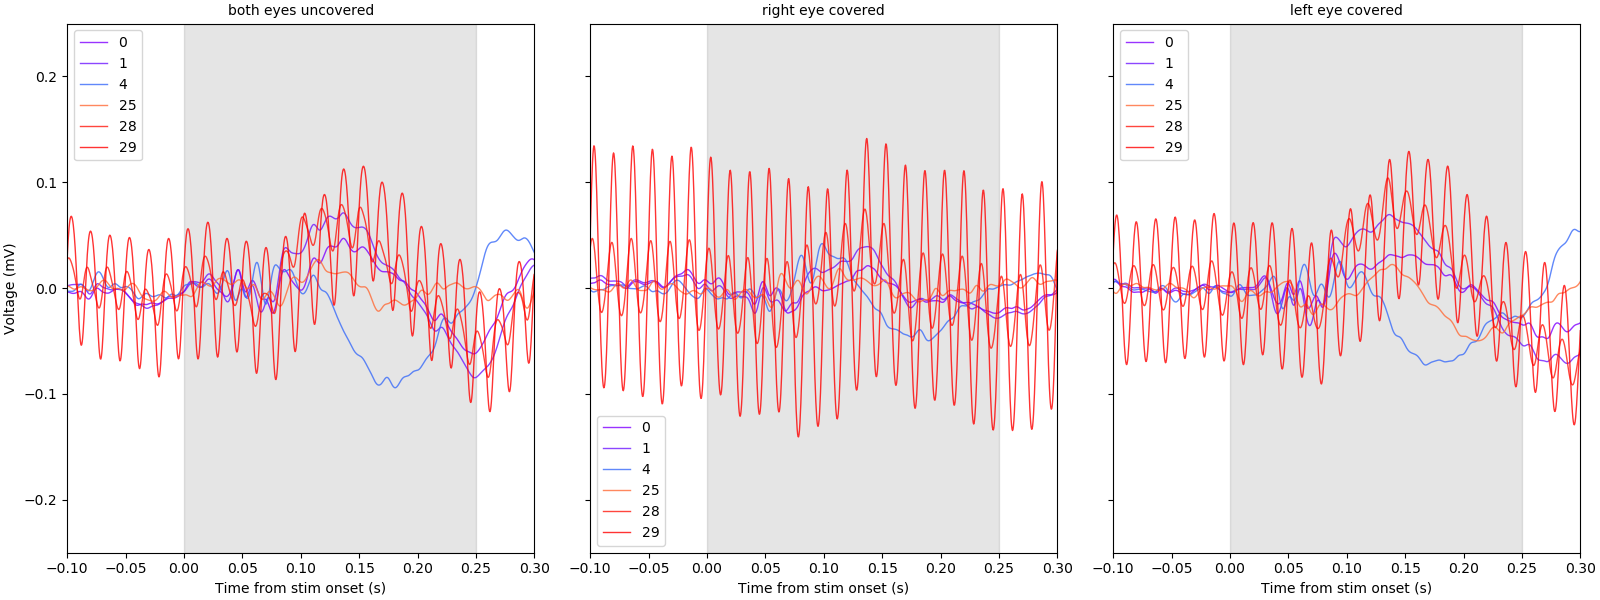

Text(0, 0.5, 'Voltage (mV)')

In [18]:
plstim = 'fullscreen'
plparam = 'white'
# plotsweeps = {0: 'both eyes uncovered', 1: 'left eye covered'} # vis1
# plotsweeps = {0: 'right eye covered', 2: 'both eyes uncovered'} # vis2
plotsweeps = {0: 'both eyes uncovered', 1: 'right eye covered', 2: 'left eye covered'} # vis3
# sweepcolors = ['b', 'g']

prex = .1 # ms before stim to plot
postx = .3 # ms after stim to plot
ylimit = 0.25 # mV

chcolors = cm.rainbow(np.linspace(0, 1, len(eeg_chs)))
fig, axs = plt.subplots(1, len(plotsweeps.keys()), figsize=(16,6), sharex=True, sharey=True, constrained_layout=True)

for ax, (sweepi, status) in zip(axs, plotsweeps.items()):
    timex = comavg_filtered_traces[plstim][plparam][sweepi][0]
    plottraces = comavg_filtered_traces[plstim][plparam][sweepi][1]/1000 # make them into mV
    plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))
    for chi in [0,1,4,25,28,29]: # eeg_chs:
        ax.plot(timex[plot_inds], plottraces[plot_inds, chi], color=chcolors[chi], linewidth=1, alpha=0.8)
    ax.axvspan(0, 0.25, color='k', alpha=0.1)
    ax.set_xlabel('Time from stim onset (s)')
    ax.set_title(status)
    ax.legend([0,1,4,25,28,29])

axs[0].set_xlim([-prex, postx])
axs[0].set_ylim([-ylimit, ylimit])
axs[0].set_ylabel('Voltage (mV)')

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'EEG_wcomavg_white_vis3.png'), transparent=True)

<IPython.core.display.Javascript object>


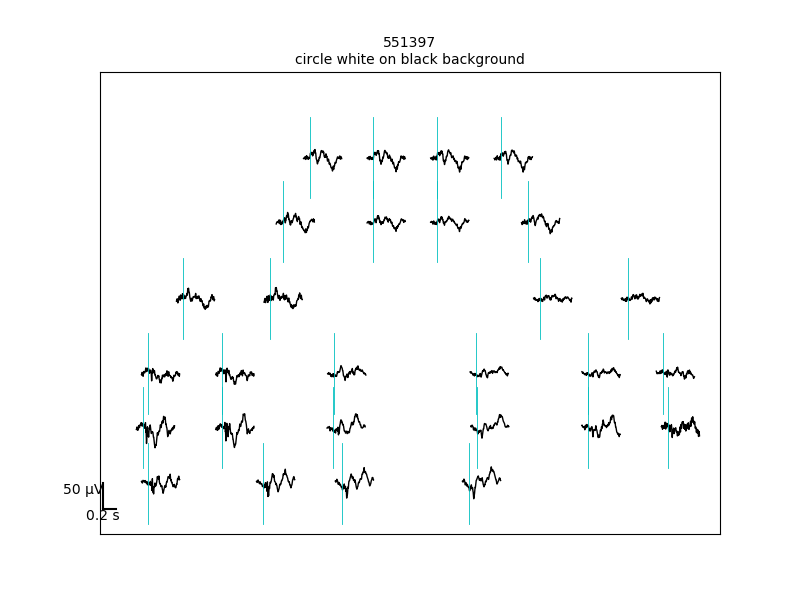

In [40]:
plstim = 'circle'
plparam = 'white'
plsweep = 1
pltraces = comavg_filtered_traces # filtered_traces

xmult = 1.0
ymult = 100
prex = .1 # ms before stim to plot
postx = .5 # ms after stim to plot

timex = pltraces[plstim][plparam][plsweep][0]
plottraces = pltraces[plstim][plparam][plsweep][1]
pinds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(8,6))
for chi in eeg_chs:
    if chi in all_good_chs:
        tracec = 'k'
    else:
#         tracec = 'r'
        continue
    ax.plot(
        timex[pinds] + (exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult),
        plottraces[pinds, chi] + (exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult),
        tracec,
        linewidth=1
    )
    ax.plot([0.+(exp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),0.+(exp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
        [-80+(exp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),80+(exp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
        color='c', linewidth=0.6)
#     ax.plot([0.06+(exp.EEG_channel_coordinates['ML'].iloc[chi]*xmult),0.06+(exp.EEG_channel_coordinates['ML'].iloc[chi]*xmult)],
#         [-40+(exp.EEG_channel_coordinates['AP'].iloc[chi]*ymult),40+(exp.EEG_channel_coordinates['AP'].iloc[chi]*ymult)],
#         color='r', linewidth=0.6)
    if chi == 0:
        mx = timex[0] + exp.EEG_channel_coordinates['ML'].iloc[chi] * xmult * 1.05
        my = exp.EEG_channel_coordinates['AP'].iloc[chi] * ymult

x_len = .2 # x scale bar length in ms
y_len = 50 # y scale bar length in uV
ax.plot([mx, mx+x_len], [my-y_len, my-y_len], 'k') # horizontal scale bar
ax.plot([mx, mx], [my-y_len, my], 'k') # vertical scale bar
ax.annotate(('{} s'.format(x_len)), xy=(mx,my-y_len), xycoords='data', ha='center', va='top')
ax.annotate(('{} \u03BCV'.format(y_len)), xy=(mx,my), xycoords='data', ha='right', va='top')

ax.set_xlim([mx-xmult*0.05, -mx+xmult*0.2])
ax.set_ylim([my-ymult, ymult*4])

# ax.set_title('{}\n{} {}, {}'.format(exp.mouse, plstim, str(plparam), plotsweeps[plsweep]))
ax.set_title('{}\n{} {} on black background'.format(exp.mouse, plstim, str(plparam)))
plt.tick_params(axis='x', bottom=False, labelbottom=False)
plt.tick_params(axis='y', left=False, labelleft=False)

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'VEP_comavgref_vis2_sweep{:d}.png'.format(plsweep)), transparent=True)

Plot all stim amps side by side

In [ ]:
len(avg_filtered_traces['biphasic'])

In [ ]:
pick_stim = 'biphasic'
pick_sweep = 0
pick_traces = avg_filtered_traces # avg_traces or avg_filtered_traces

plot_name = 'rbbf_allamps_awake.png'

prex = 100 # ms before stim to plot
postx = 500 # ms after stim to plot
ylimit = 0.3 # mV

fig, axs = plt.subplots(1, len(pick_traces[pick_stim]), sharex=True, sharey=True, figsize=(16,9/3), constrained_layout=True)
for ax, parami in zip(axs, pick_traces[pick_stim].keys()):
    timex = pick_traces[pick_stim][parami][pick_sweep][0]
    plottraces = pick_traces[pick_stim][parami][pick_sweep][1]/1000 # make them into mV
    plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

    for chi in eeg_chs:
        ax.plot(timex[plot_inds], plottraces[plot_inds,chi], color=dist_scatter.to_rgba(ch_distances[chi]), linewidth=0.8)

    ax.axvspan(-.001, .001, color='g', alpha=0.5)

    ax.set_xlim([-prex, postx])
    ax.set_ylim([-ylimit, ylimit])
#     ax.set_xlabel('Time from stim onset (s)')
    # ax.set_ylabel('Voltage (mV)')
    ax.set_title('{} \u03BCA stim'.format(str(parami)))
#     ax.set_xticklabels('')
#     ax.set_yticklabels('')

axs[0].set_ylabel('Voltage (mV)')
# cb = fig.colorbar(dist_scatter, ax=axs[2])
# cb.set_label('Distance (mm)')

## Save ##
# fig.savefig(os.path.join(plotsavedir, plot_name), transparent=True)

### Quantify responses to different amplitudes

In [95]:
comp_states = {0: 'awake', 1: 'isoflurane'}
# AUC_window = {'500_ms': [0.005, 0.5], 'first_100_ms': [0.005, 0.105], 'second_100_ms': [0.1, 0.2]}
AUC_window = [0.005, 0.5] # [0.1, 0.2]
PCI_params = {
    'baseline_window': (-0.5, -0.005), # s before stim for baseline, my default: (-500, -1)
    'response_window': (0.005, 0.5), # s after stim for response, my default: (1, 500)
    'k': 1.2,
    'min_snr': 1.6, # my default: 1.1
    'max_var': 99,
    'embed': False,
    'n_steps': 100,
}

AUC_list = []
state_list = []
amp_list = []
ch_list = []
PCI_list = []
nPCs_list = []
PCIstate_list = []
PCIamp_list = []
final_traces = {}
for ampi, sweepdict in filtered_traces['biphasic'].items():
    final_traces[ampi] = {}
    good_list = [good_chs['biphasic'][ampi][x] for x in comp_states.keys()]
    common_good_chs = np.intersect1d(good_list[0], good_list[1], assume_unique=True)
    
    NUM_TRIALS = min([sweepdict[x][1].shape[2] for x in comp_states.keys()])
    
    for sweepi, statei in comp_states.items():
        timex = sweepdict[sweepi][0]
        mean_data = np.mean(sweepdict[sweepi][1][:, :, :NUM_TRIALS], axis=2)
        final_traces[ampi][sweepi] = [timex, mean_data, common_good_chs]
        
        ## calculate AUC in window ##
        preinds = np.nonzero((timex >= -AUC_window[1]) & (timex <= -AUC_window[0]))[0]
        baseline_auc = integrate.simps(np.abs(mean_data[preinds, :]), timex[preinds], axis=0, even='last')
        postinds = np.nonzero((timex >= AUC_window[0]) & (timex <= AUC_window[1]))[0]
        response_auc = integrate.simps(np.abs(mean_data[postinds, :]), timex[postinds], axis=0, even='last')

        AUC_list.append(response_auc[common_good_chs] - baseline_auc[common_good_chs])
        state_list.append([statei] * common_good_chs.shape[0])
        amp_list.append([ampi] * common_good_chs.shape[0])
        ch_list.append(common_good_chs)
        
        ## calculate PCI ##
        full_PCI_output = calc_PCIst(
            mean_data[:, common_good_chs].T,
            timex,
            full_return=True,
            **PCI_params
        )
        PCI_list.append(full_PCI_output['PCI'])
        nPCs_list.append(full_PCI_output['n_dims'])
        PCIstate_list.append(statei)
        PCIamp_list.append(ampi)

AUC_df = pd.DataFrame({
    'response_mag': np.concatenate(AUC_list),
    'electrode': np.concatenate(ch_list),
    'stim_amp': np.concatenate(amp_list),
    'state': np.concatenate(state_list)
})
PCI_df = pd.DataFrame({
    'PCI': PCI_list,
    'num_PCs': nPCs_list,
    'stim_amp': PCIamp_list,
    'state': PCIstate_list
})

<IPython.core.display.Javascript object>


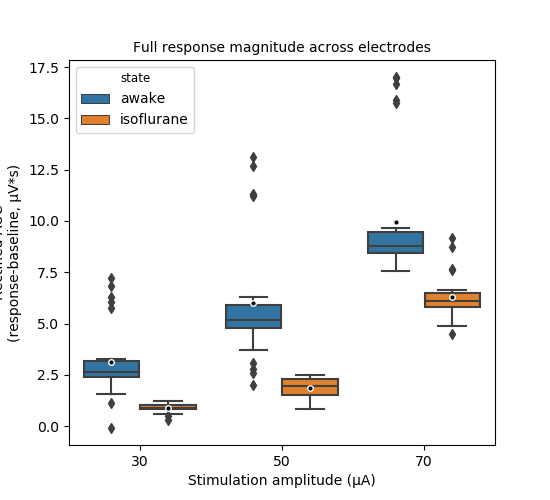

In [99]:
## Box plot for AUC ##
fig, ax = plt.subplots(figsize=(5.5,5))
bxplt = sns.boxplot(
    x='stim_amp',
    y='response_mag',
    hue='state',
    data=AUC_df,
    ax=ax,
    showmeans=True,
    meanprops={'marker':'.', 'markerfacecolor':'black', 'markeredgecolor':'white', 'markersize':'8'}
)
bxplt.set_xlabel('Stimulation amplitude (\u03BCA)')
bxplt.set_ylabel('Rectified AUC\n(response-baseline, \u03BCV*s)')
bxplt.set_title('Full response magnitude across electrodes')

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'Response5-500ms_AUC_goodchs.png'), transparent=True)

<IPython.core.display.Javascript object>


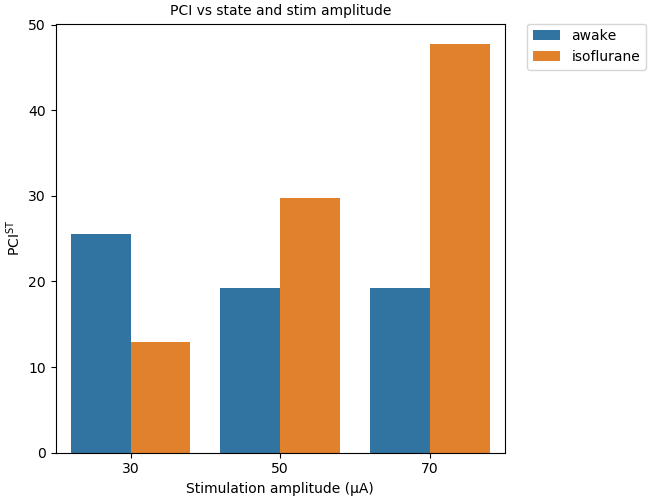

In [100]:
## Bar plot for PCI ##
fig, ax = plt.subplots(figsize=(6.5,5), constrained_layout=True)
cplt = sns.barplot(
    x='stim_amp',
    y='PCI',
    hue='state',
    data=PCI_df,
    ax=ax
)
cplt.set_xlabel('Stimulation amplitude (\u03BCA)')
cplt.set_ylabel('$\mathregular{PCI^{ST}}$')
cplt.set_title('PCI vs state and stim amplitude')
cplt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'PCI_allamps_goodchs.png'), transparent=True)

<IPython.core.display.Javascript object>


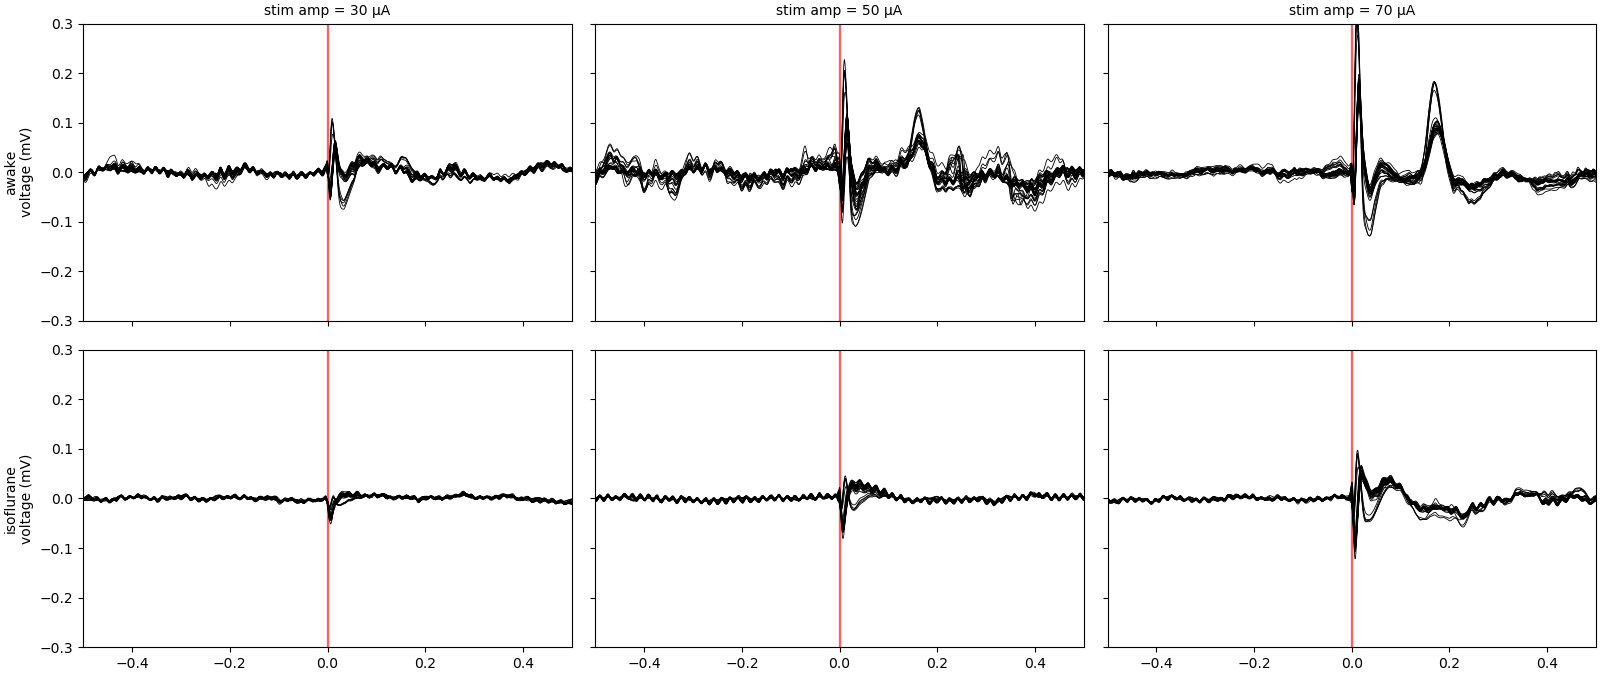

In [101]:
prex = .5 # ms before stim to plot
postx = .5 # ms after stim to plot
ylimit = 0.3 # mV

fig, axs = plt.subplots(len(comp_states.keys()), len(final_traces.keys()), figsize=(16,9*0.75), sharex=True, sharey=True, constrained_layout=True)
for sweepi, statei in comp_states.items():
    for col, parami in enumerate(final_traces.keys()):
        timex = final_traces[parami][sweepi][0]
        plottraces = final_traces[parami][sweepi][1][:, final_traces[parami][sweepi][2]]/1000 # make them into mV
        plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

        axs[sweepi,col].plot(timex[plot_inds], plottraces[plot_inds,:], color='k', linewidth=0.6)
        axs[sweepi,col].axvspan(-.001, .001, color='r', alpha=0.5)
        
        if col == 0:
            axs[sweepi,col].set_ylabel('{:s}\nvoltage (mV)'.format(statei))
        if sweepi == 0:
            axs[sweepi,col].set_title('stim amp = {:s} \u03BCA'.format(parami))

axs[0,0].set_xlim([-prex, postx])
axs[0,0].set_ylim([-ylimit, ylimit])

## Save ##
# fig.savefig(os.path.join(plotsavedir, 'estim_EEG_allamps_states.png'), transparent=True)